In [17]:
compounds_str = """
part1-CO2_50-FeO_50:
CO2: 50%
FeO: 50%

part2-CO_20-Fe_50-AgO_20-AlO_10:
CO: 20%
Fe: 50%
AgO: 20%
AlO: 10%

part3-HCO2_15-FeO2_60-Ag_25:
HCO2: 15%
FeO2: 60%
Ag: 25%

part4-HCO2_20-FeO2_60-Ag_20:
HCO2: 20%
FeO2: 60%
Ag: 20%
"""
import torch
import datetime
from typing import List, Tuple, Literal
from dataclasses import dataclass

from mark_essential_oils import Config, gen_examples, train

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from IPython import display

# import seaborn as sns
# import pandas
# sns.set_theme()

@dataclass
class Annotation:
    text: str
    xy: Tuple[float, float]
    axes: str
    textxy: Tuple[float, float] = None


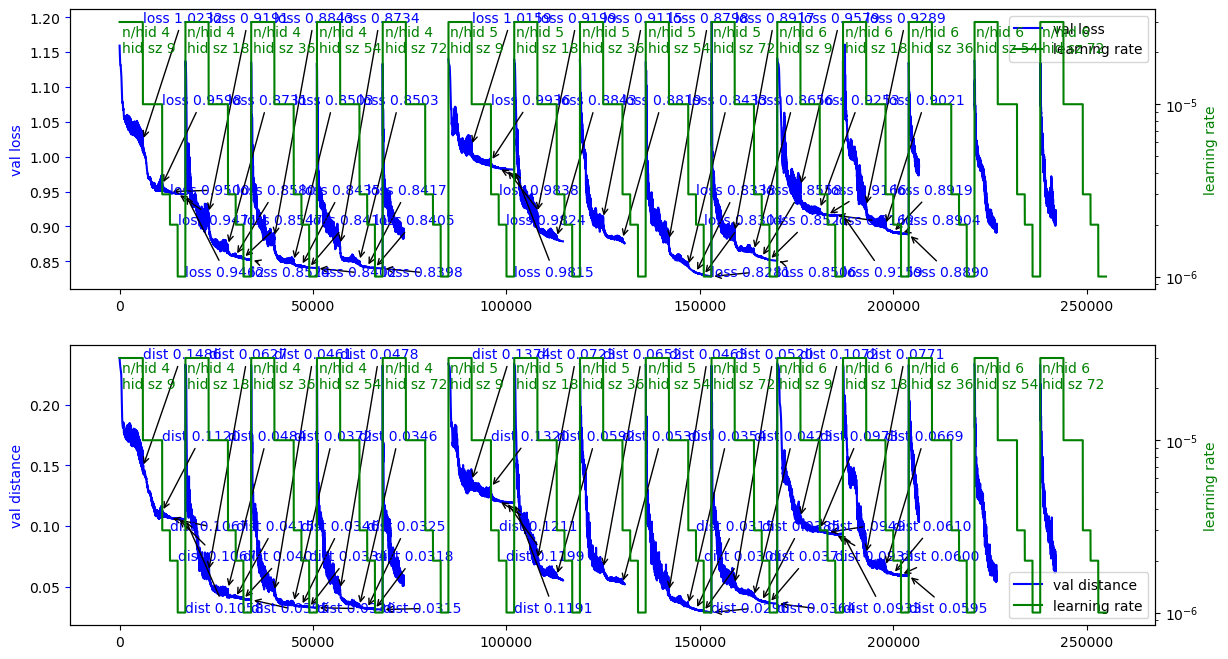

saved outputs/mark_essential_oils2/results-20230216-150136.png


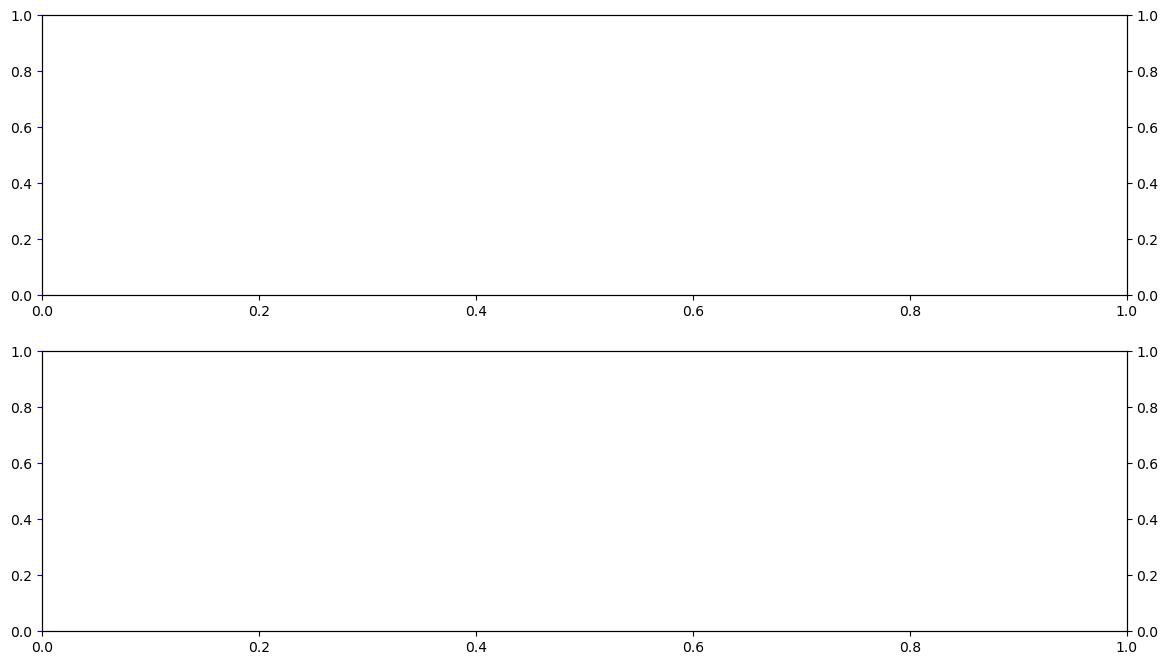

In [18]:
%matplotlib inline
cfg = Config(compounds_str)
cfg.setup(num_hidden=3, hidden_size=len(cfg.all_mol_names), lr=1e-4)

train_losses = list()
val_losses = list()
val_diffs = list()
val_dists = list()
learning_rates = list()
annotations: List[Annotation] = list()

color_val = "blue"
color_lr = "green"
fig = plt.gcf()

def reset_plot():
    plt.rcParams["figure.figsize"] = (30, 20) # (w, h)
    fig.clear()
    ax_val_losses = fig.add_subplot(2, 1, 1, label="val loss")
    ax_val_dists = fig.add_subplot(2, 1, 2, label="val distance")

    all_axes = [ax_val_losses, ax_val_dists]
    all_axes_lr = [ax.twinx() for ax in all_axes]

    for ax in all_axes_lr:
        ax.set_yscale("log")
        ax.set_label("learning rate")
        ax.set_ylabel(ax.get_label(), color=color_lr)

    for ax in all_axes:
        ax.set_ylabel(ax.get_label(), color=color_val)
        ax.tick_params('y', color=color_val)

    return all_axes, all_axes_lr

num_mol = len(cfg.all_mol_names)
hp_num_batches = 10
hp_batch_size = 1000
hp_learning_rates = {3e-5: 6000, 1e-5: 5000, 3e-6: 2000, 2e-6: 2000, 1e-6: 2000}
hp_num_hidden = [4, 5, 6]
hp_hidden_size = [num_mol, num_mol * 2, num_mol * 4, num_mol * 6, num_mol * 8]

# TODO - only for fast debugging
# hp_learning_rates = {k: v//100 for k, v in hp_learning_rates.items()}

data_train = gen_examples(cfg, hp_num_batches, hp_batch_size)
data_val = gen_examples(cfg, hp_num_batches, hp_batch_size)

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = ["outputs", "mark_essential_oils2", "results-" + timestr + ".png"]
filename = "/".join(filename)

total_epochs = 0
for num_hidden in hp_num_hidden:
    for hidden_size in hp_hidden_size:
        cfg.setup(num_hidden=num_hidden, hidden_size=hidden_size, lr=1e-4)

        print()
        print(f"num_hidden {num_hidden}, hidden_size {hidden_size}")
        epochs_at_lr = 0

        for lridx, (lr, epochs) in enumerate(hp_learning_rates.items()):
            print(f"lr = {lr} (num_hidden {num_hidden}, hidden_size {hidden_size})")
            cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=lr)

            tlosses, vlosses, vdists = train(cfg, epochs, data_train, data_val)

            train_losses.extend(tlosses)
            val_losses.extend(vlosses)
            val_dists.extend(vdists)
            learning_rates.extend([lr] * epochs)

            all_axes, all_axes_lr = reset_plot()
            all_vals = [val_losses, val_dists]

            # annotation for hyper param change
            lrpos = (float(total_epochs), learning_rates[total_epochs])
            if lridx == 0:
                annotext = f"n/hid {num_hidden}\nhid sz {hidden_size}"
                anno = Annotation(text=annotext, xy=lrpos, axes="learning rate")
                annotations.append(anno)

            # annotation for ending loss for that learning rate
            textpos = (total_epochs + epochs - 1, learning_rates[-1])
            annotext = f"loss {val_losses[-1]:.4f}"
            annopos = (textpos[0], val_losses[-1])
            anno = Annotation(annotext, xy=annopos, axes="val loss", textxy=textpos)
            annotations.append(anno)

            annotext = f"dist {val_dists[-1]:.4f}"
            annopos = (textpos[0], val_dists[-1])
            anno = Annotation(annotext, xy=annopos, axes="val distance", textxy=textpos)
            annotations.append(anno)

            for axes, axes_lr, vals in zip(all_axes, all_axes_lr, all_vals):
                axes.plot(vals, color=color_val, label=axes.get_label())
                lines, labels = axes.get_legend_handles_labels()

                axes_lr.plot(learning_rates, color=color_lr, label=axes_lr.get_label())
                lines_lr, labels_lr = axes_lr.get_legend_handles_labels()

                axes.legend(lines + lines_lr, labels + labels_lr)

                for anno in annotations:
                    kvargs = {}
                    use_axes: plt.Axes = None
                    if anno.axes == axes_lr.get_label():
                        xoff = 2
                        yoff = (anno.text.count("\n") + 1) * -15
                        color = color_lr
                        kvargs = dict(xytext=(xoff, yoff), textcoords='offset pixels')
                        use_axes = axes_lr

                    elif anno.axes == axes.get_label():
                        color = color_val
                        use_axes = axes

                        if anno.textxy is not None:
                            # con = ConnectionPatch(xyA=anno.xy, axesA=axes,
                            #                       xyB=anno.textxy, axesB=axes_lr,
                            #                       coordsA="data", coordsB="data")
                            # axes_lr.add_artist(con)
                            kvargs = dict(xytext=anno.textxy, textcoords=axes_lr.transData, arrowprops=dict(arrowstyle='->'))
                    else:
                        continue

                    use_axes.annotate(text=anno.text, xy=anno.xy, color=color, **kvargs)
                
            display.clear_output(True)
            display.display(fig)

            epochs_at_lr += epochs
            total_epochs += epochs

            fig.savefig(filename)
            print(f"saved {filename}")

            for ax in [*all_axes, *all_axes_lr]:
                ax.clear()


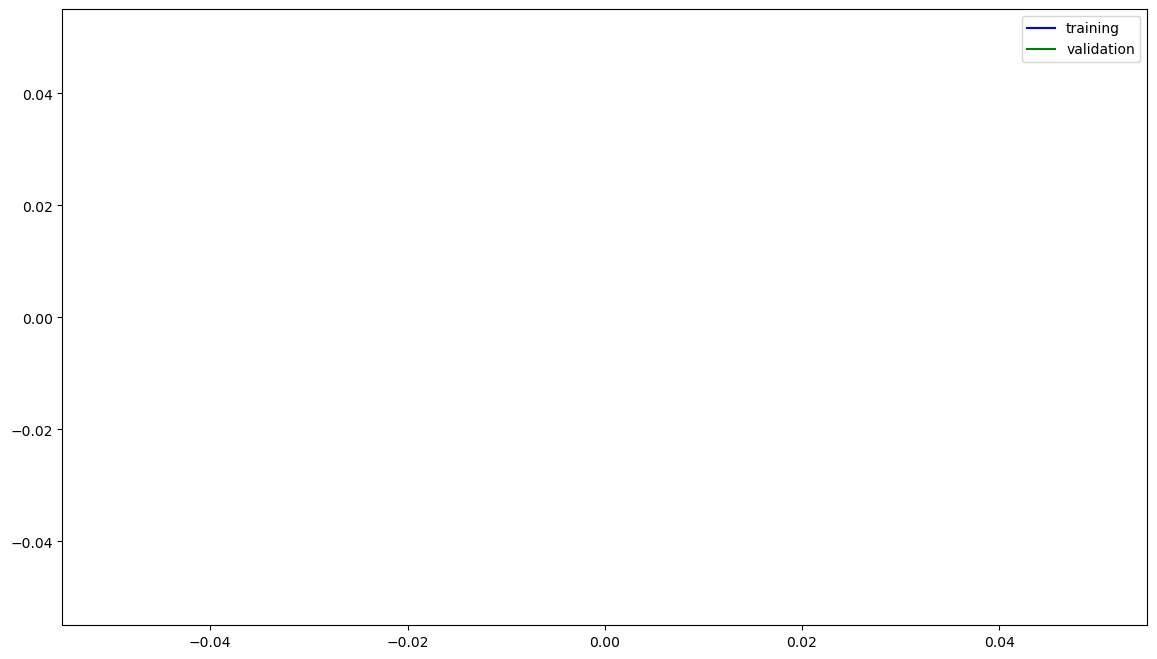

In [19]:
smoothed = torch.Tensor(tlosses).view(-1, 50).mean(dim=1)
plt.plot(smoothed, label="training", color="blue")
smoothed = torch.Tensor(vlosses).view(-1, 50).mean(dim=1)
plt.plot(smoothed, label="validation", color="green")
plt.legend()

